## Construction Site Safety PPE Detection
---
In this notebook I will train Yolo v9 model to detect PPE (Personal Protective Equipment), using this existing dataset from Roboflow

**File Structure :**

```bash
DATASETS
├───test
│   ├───images
│   └───labels
├───train
│   ├───images
│   └───labels
└───valid
    ├───images
    └───labels
```

In [1]:
import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

In [2]:
dataset_dir = './datasets'
output_dir = './'

BASE_MODEL = 'yolov9e'

classes = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle']
n_classes = len(classes)

In [3]:
dict_file = {
    'train': os.path.join('train'),
    'val': os.path.join('valid'),
    'test': os.path.join('test'),
    'nc': n_classes,
    'names': classes
}

with open(os.path.join(output_dir, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [4]:
with open(os.path.join(output_dir, 'data.yaml'), 'r') as file:
    try:
        yaml_data = yaml.safe_load(file)
        if yaml_data:
            formatted_yaml = yaml.dump(yaml_data, default_style=False)
            print(formatted_yaml)
    except yaml.YAMLError as e:
        print("Error reading YAML:", e)

names:
- Hardhat
- Mask
- NO-Hardhat
- NO-Mask
- NO-Safety Vest
- Person
- Safety Cone
- Safety Vest
- machinery
- vehicle
nc: 10
test: test
train: train
val: valid



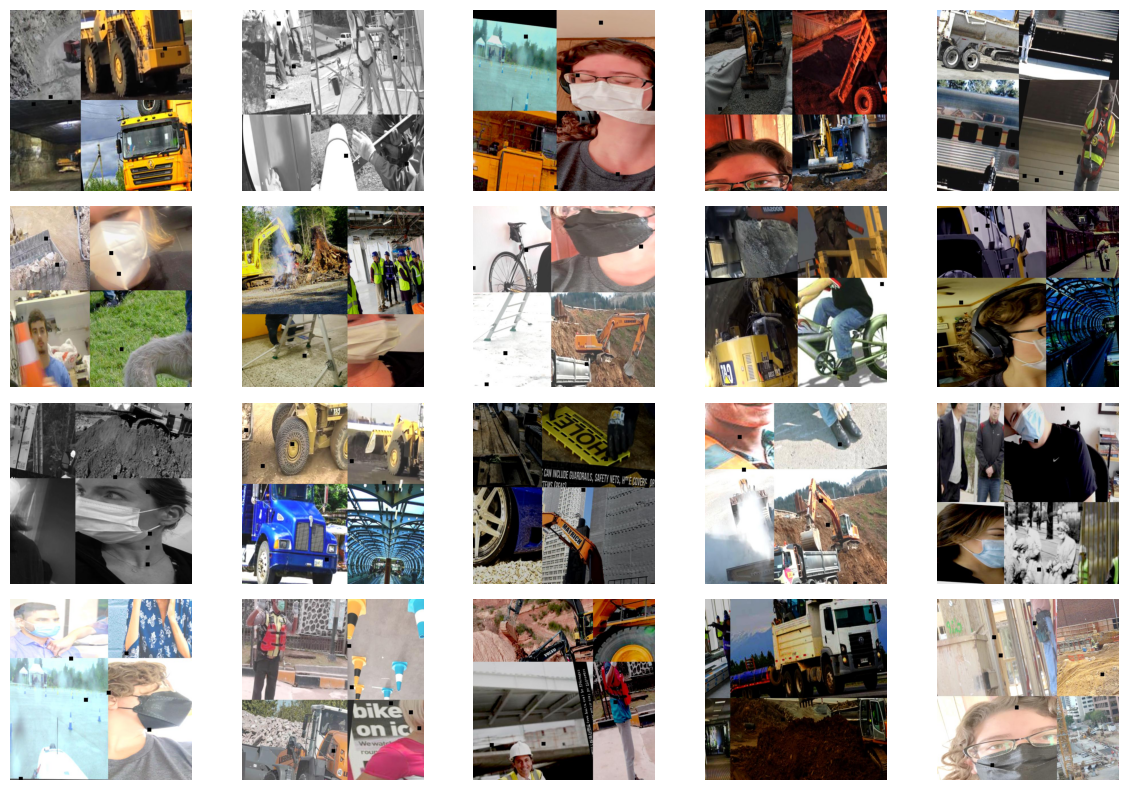

In [5]:
image_files = []
for f in os.listdir(dataset_dir + '/train/images/'):
    if f.endswith(('.jpg', '.png', '.jpeg', '.gif')):
        image_files.append(f)

if len(image_files) < 20:
    raise ValueError("Not enough images in the folder")

selected_files = random.sample(image_files, 20)

fig = plt.figure(figsize=(12, 8))

for i, file_name in enumerate(selected_files):
    img_path = os.path.join(dataset_dir + '/train/images/', file_name)
    img = Image.open(img_path)
    
    ax = fig.add_subplot(4, 5, i + 1)
    ax.imshow(img)
    ax.axis('off')

for i in range(20, 4 * 5):
    fig.delaxes(fig.axes[i])

plt.tight_layout()
plt.show()

In [6]:
example_image = '-1975-_png_jpg.rf.b5622016579bca7e2e993de3470405e0.jpg'

In [7]:
img = cv2.imread(dataset_dir+'/train/images/'+example_image)

if img is None:
    raise ValueError("Could not read image file")

properties = {
    "width": img.shape[1],
    "height": img.shape[0],
    "channels": img.shape[2] if len(img.shape) == 3 else 1,
    "dtype": img.dtype,
}

pd.DataFrame(properties, index=[0])

width  height  channels  dtype
0    640     640         3  uint8

In [8]:
class_idx = {str(i): classes[i] for i in range(n_classes)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {classes[i]: 0 for i in range(n_classes)}

    path = os.path.join(dataset_dir, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
dataset_stats_df

Mode  Hardhat  Mask  NO-Hardhat  NO-Mask  NO-Safety Vest  Person  \
0  train     1314  1096        1380     1531            1864    2526   
1  valid       42    19          37       44              56      84   
2   test       30    16          25       30              36      59   

   Safety Cone  Safety Vest  machinery  vehicle  Data_Volume  
0          631         1319       2101      744         2605  
1           13           28         26       16          114  
2            8           22         22       15           82

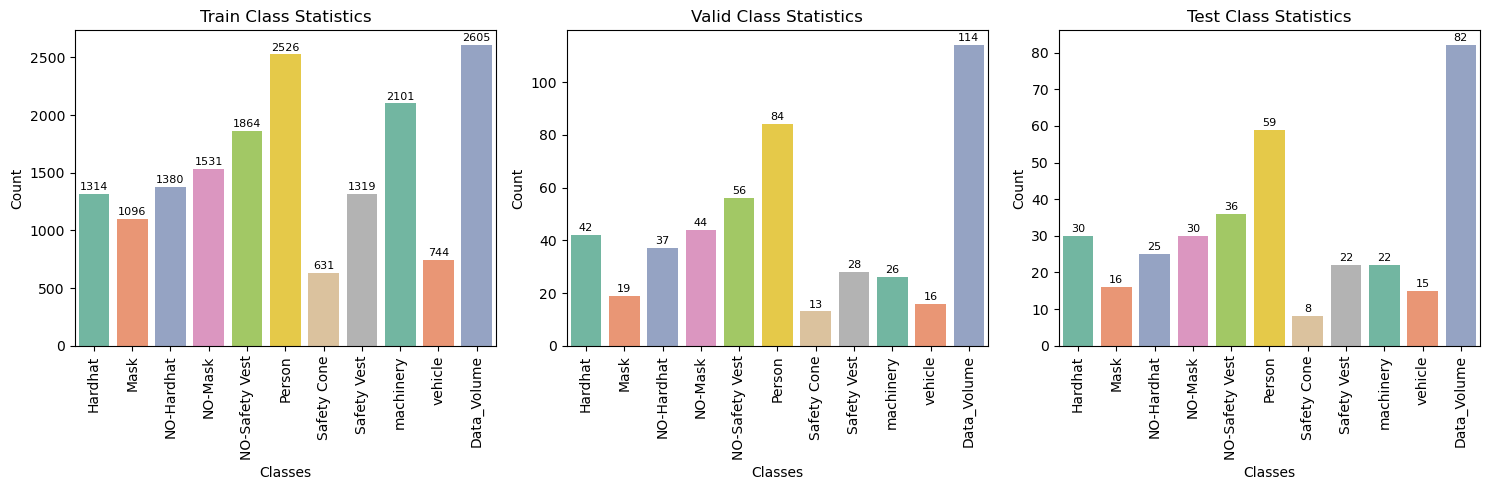

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )
    
    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90) 

    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

In [10]:
for mode in ['train', 'valid', 'test']:
    print(f'\nImage sizes in {mode} set:')

    img_size = 0
    for file in glob.glob(os.path.join(dataset_dir, mode, 'images', '*')):

        image = Image.open(file)

        if image.size != img_size:
            print(f'{image.size}')
            img_size = image.size
            print('\n')


Image sizes in train set:
(640, 640)



Image sizes in valid set:
(640, 640)



Image sizes in test set:
(640, 640)




In [11]:
model = YOLO(f'{BASE_MODEL}.pt') # yolov9e.pt

results = model.predict(
    source = dataset_dir + '/train/images/' + example_image,

    classes = [0],
    conf = 0.30,
    imgsz = (properties['height'], properties['width']),

    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True,
)

100%|███████████████████████████████████████████████████████████████████████████████| 112M/112M [01:03<00:00, 1.84MB/s]



image 1/1 C:\Users\KIIT\Documents\GitHub\notebooks\YoloV8\datasets\train\images\-1975-_png_jpg.rf.b5622016579bca7e2e993de3470405e0.jpg: 640x640 5 persons, 9284.9ms
Speed: 10.0ms preprocess, 9284.9ms inference, 10.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict
1 label saved to runs\detect\predict\labels


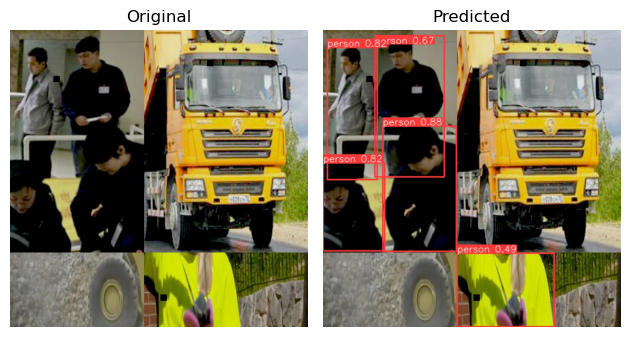

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(Image.open(dataset_dir + '/train/images/' + example_image))
ax1.set_title('Original')
ax1.axis('off')

ax2.imshow(Image.open('./runs/detect/predict/' + example_image))
ax2.set_title('Predicted')
ax2.axis('off')

plt.tight_layout()
plt.show()

In [13]:
model.train(
    data = os.path.join(output_dir, 'data.yaml'),

    task = 'detect',

    imgsz = (properties['height'], properties['width']),

    epochs = 1,
    batch = 16,
    optimizer = 'auto',
    lr0 = 1e-3,
    lrf = 0.01,
    weight_decay = 5e-4,
    dropout = 0.0,
    fraction = 0.05,
    patience = 20,
    profile = False,
    label_smoothing = 0.0,
    seed = 88,
    
    val = True,
    amp = True,    
    exist_ok = True,
    resume = False,
    verbose = False
)

Ultralytics YOLOv8.2.34  Python-3.11.7 torch-2.3.1+cu118 CPU (AMD Ryzen 7 5700U with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov9e.pt, data=./data.yaml, epochs=1, time=None, patience=20, batch=16, imgsz=(640, 640), save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=0.05, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True

train: Scanning C:\Users\KIIT\Documents\GitHub\notebooks\YoloV8\datasets\train\labels.cache... 130 images, 0 background

train: WARNING  C:\Users\KIIT\Documents\GitHub\notebooks\YoloV8\datasets\train\images\004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed



val: Scanning C:\Users\KIIT\Documents\GitHub\notebooks\YoloV8\datasets\valid\labels.cache... 114 images, 10 backgrounds


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 298 weight(decay=0.0), 310 weight(decay=0.0005), 309 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G      3.251      4.344      3.524         18        640: 100%|██████████| 9/9 [2:21:51<00:00, 945
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [33:33<0


                   all        114        697    0.00117     0.0675    0.00155   0.000447

1 epochs completed in 2.970 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 117.3MB
Optimizer stripped from runs\detect\train\weights\best.pt, 117.3MB

Validating runs\detect\train\weights\best.pt...
Ultralytics YOLOv8.2.34  Python-3.11.7 torch-2.3.1+cu118 CPU (AMD Ryzen 7 5700U with Radeon Graphics)
YOLOv9e summary (fused): 687 layers, 57384110 parameters, 0 gradients, 189.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [31:46<0


                   all        114        697    0.00117     0.0675    0.00157    0.00045
Speed: 10.9ms preprocess, 16634.3ms inference, 0.0ms loss, 41.0ms postprocess per image
Results saved to runs\detect\train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001F7A1328550>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,   

In [16]:
model.export(
    format = 'onnx',
    imgsz = (properties['height'], properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics YOLOv8.2.34  Python-3.11.7 torch-2.3.1+cu118 CPU (AMD Ryzen 7 5700U with Radeon Graphics)
YOLOv9e summary (fused): 687 layers, 57384110 parameters, 0 gradients, 189.2 GFLOPs

PyTorch: starting from 'runs\detect\train\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 14, 8400) (111.8 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 14.4/14.4 MB 11.9 MB/s eta 0:00:00

requirements: AutoUpdate success  137.9s, installed 1 package: ['onnx>=1.12.0']
requirements:  Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.16.1 opset 17...
ONNX: export success  167.0s, saved as 'runs\detect\train\weights\best.onnx' (219.3 MB)

Export complete (193.0s)
Results saved to C:\Users\KIIT\Documents\GitHub\notebooks\YoloV8\runs\detect\train\weights
Predict:

'runs\\detect\\train\\weights\\best.onnx'

In [17]:
results_paths = [
    i for i in
    glob.glob(f'{output_dir}runs/detect/train/*.png') +
    glob.glob(f'{output_dir}runs/detect/train/*.jpg')
    if 'batch' not in i
]

results_paths

['./runs/detect/train\\confusion_matrix.png',
 './runs/detect/train\\confusion_matrix_normalized.png',
 './runs/detect/train\\F1_curve.png',
 './runs/detect/train\\PR_curve.png',
 './runs/detect/train\\P_curve.png',
 './runs/detect/train\\results.png',
 './runs/detect/train\\R_curve.png',
 './runs/detect/train\\labels.jpg',
 './runs/detect/train\\labels_correlogram.jpg']

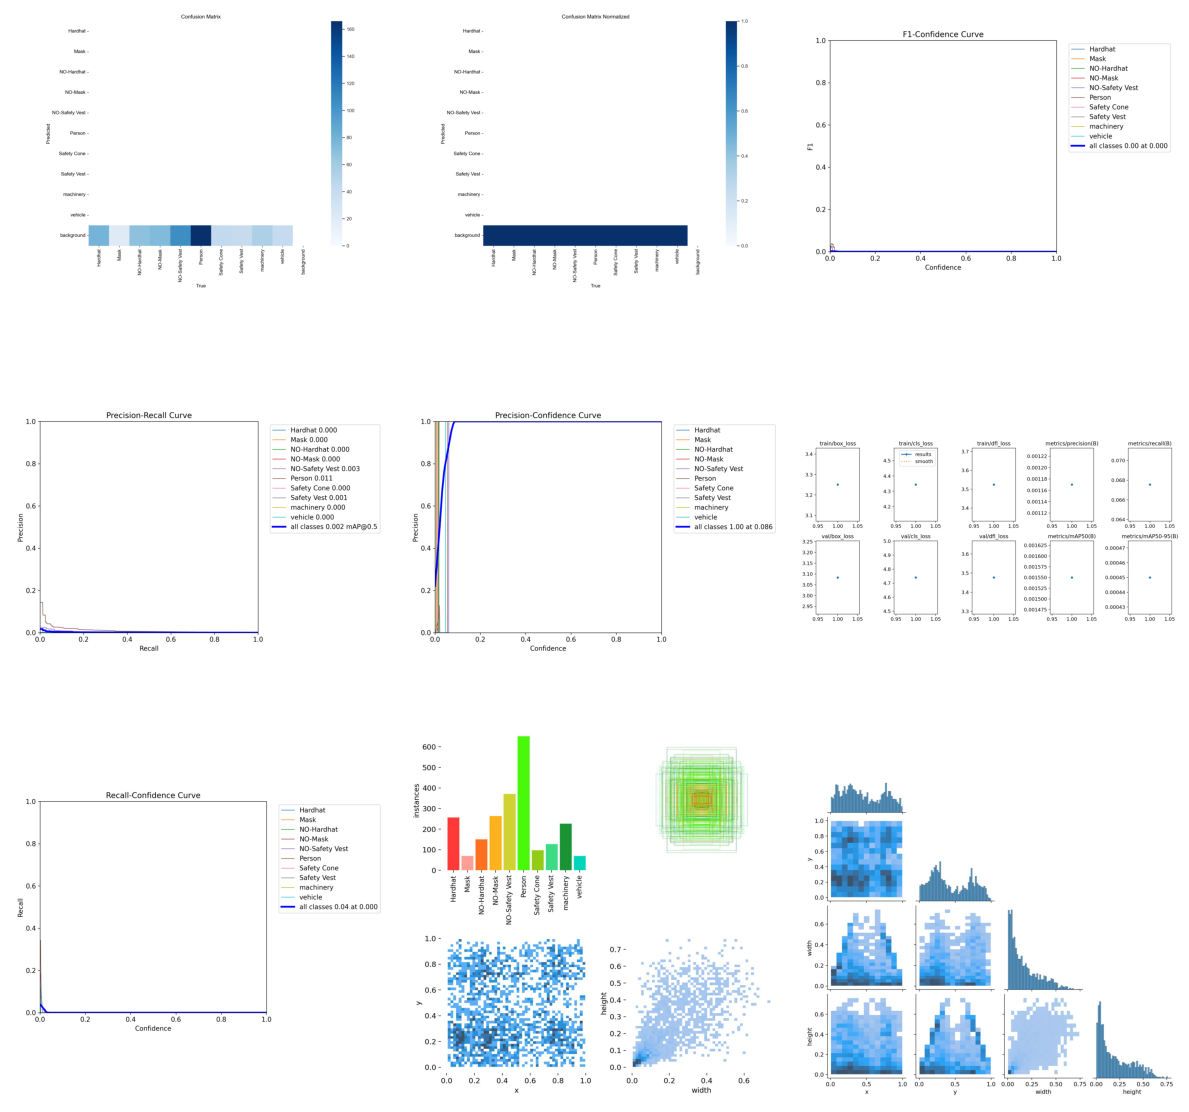

In [18]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i, path in enumerate(results_paths):
    row = i // 3
    col = i % 3
    img = Image.open(path)
    axes[row, col].imshow(img)
    axes[row, col].axis('off')

plt.tight_layout()

plt.show()

In [19]:
df = pd.read_csv(f'{output_dir}/runs/detect/train/results.csv')
df

epoch           train/box_loss           train/cls_loss  \
0                        1                   3.2507                   4.3435   

            train/dfl_loss     metrics/precision(B)        metrics/recall(B)  \
0                   3.5242                  0.00117                  0.06755   

          metrics/mAP50(B)      metrics/mAP50-95(B)             val/box_loss  \
0                  0.00155                  0.00045                   3.0837   

              val/cls_loss             val/dfl_loss                   lr/pg0  \
0                   4.7406                   3.4772                 0.000057   

                    lr/pg1                   lr/pg2  
0                 0.000057                 0.000057

In [21]:
validation_results_paths = [
    i for i in
    glob.glob(f'{output_dir}/runs/detect/train/*.png') +
    glob.glob(f'{output_dir}/runs/detect/train/*.jpg')
    if 'val_batch' in i
]

validation_results_paths

['.//runs/detect/train\\val_batch0_labels.jpg',
 './/runs/detect/train\\val_batch0_pred.jpg',
 './/runs/detect/train\\val_batch1_labels.jpg',
 './/runs/detect/train\\val_batch1_pred.jpg',
 './/runs/detect/train\\val_batch2_labels.jpg',
 './/runs/detect/train\\val_batch2_pred.jpg']

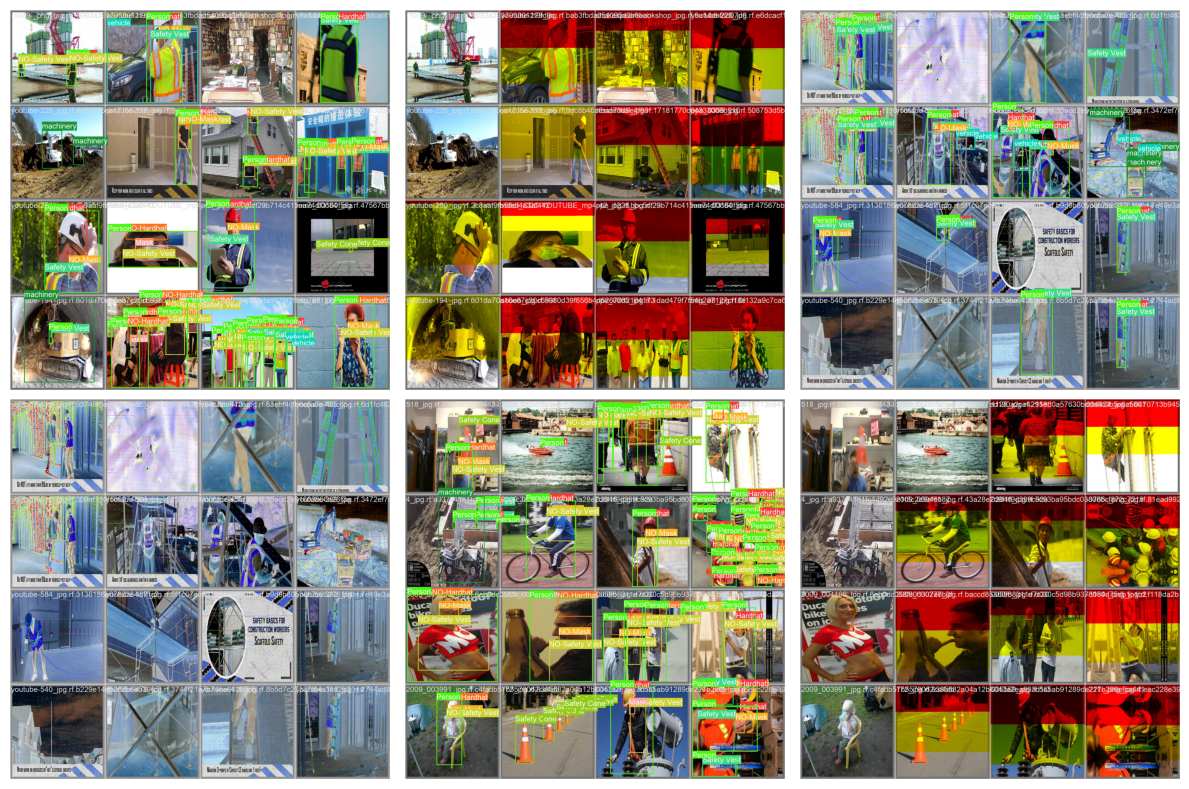

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, path in enumerate(validation_results_paths):
    row = i // 3
    col = i % 3
    img = Image.open(path)
    axes[row, col].imshow(img)
    axes[row, col].axis('off')

plt.tight_layout()

plt.show()